# Alberta Emergency Room Wait Times

### Jois Xie and Scott Veale
### DATA 602

## Table of Contents

[1. Introduction](#introduction)

[2. Wrangling](#wrangling)

[3. Setup](#setup)

[4. Daily Averages](#daily-averages)

[5. Day-Hour Heat Map](#day-hour-heat-map)

[6. Hospital Statistics](#hospital_statistics)

[7. Weather](#Weather)

[8. Conclusion](#conclusion)

## 1. Introduction
<a id="introduction"></a>

#### Purpose

   Visitors to a hospital’s Emergency Department (ED) can often expect to wait several hours between being assessed by a triage nurse and seeing a doctor. For successful treatment it is important to minimize this waiting period since many medical issues are time-sensitive. A patient’s actual wait time depends on a variety of factors including how many staff and other resources are available, how many others are waiting to be seen, and how urgently the patient needs care (Alberta Health Services, 2018). Hospital administration needs to know when the ED is expected to be busiest in order allocate hospital resources most efficiently and reduce overall wait time. And while those seeking emergency help are encouraged to visit the nearest hospital immediately, the reality is that patients will try to minimize their waiting period by choosing which hospital they visit, or at which time of day.

   ED wait times are a matter of public health for these reasons. So it is important for the general public to be aware of what factors influence how long they will have to wait to see a doctor. The purpose of this investigation is to explore these factors.

#### Data
	
   ED wait times for 19 hospitals across the province are published on the Internet by Alberta Health Services (AHS) (Alberta Health Services, 2018). The values are updated every two minutes. Non-commercial use of the data is permitted under the website’s Terms and Conditions.

   We have created a Python script that scrapes this website. To reduce the load on the AHS servers, data is collected every 5 minutes instead of every 2 minutes as it is updated. Each data point corresponds to one hospital at one point in time and records the published wait time at that hospital in minutes. Data collection began August 24th, 2018 and is ongoing. The Python script uses the BeautifulSoup library to extract the data from the HTML source code. The script is run and scheduled using an Amazon Web Services (AWS) Lambda function, and the tabular data is stored in an AWS DynamoDB database. By running an AWS DataPipeline, this data can be output in csv format which can then be loaded into the analysis tool of choice.

   In addition, a similar data collection method stores weather data every hour for cities in Alberta which have ED’s. This data can be used to see if weather is a factor in determining the length of wait times. Each weather data point includes the city, date and time, sunrise and sunset, temperature, and a string category describing the weather, eg. “Cloudy”. These data are recorded hourly because the weather API we used has rate limiting in place.

   
   The scrapers for wait times and weather are available here:
   
   https://github.com/srveale/aws-ewt/blob/master/lambda_function.py
   
   https://github.com/srveale/aws-weather/blob/master/saveWeather.py

## 2. Wrangling
<a id="wrangling"></a>

Prior to the creation of this notebook, these data wrangling tasks took place:
1. Export the data from Amazon Web Services (AWS) DynamoDB where it was being stored. This was done using an AWS DataPipeline which generated the output files and saved them to AWS S3
2. Using R, the data was converted into standard CSV format to be read by data analyis tools. For example, the row

`{id:{s:2c5665ae-a944-11e8-b32b-ba64d3f57457} waitTimeString:{s:01:39} waitTime:{n:99} hospitalName:{s:Red Deer Regional Hospital} epochTime:{n:1535297090.15} date:{s:Sun, 26 Aug 2018 15:24:50 +0000}}`

was converted to 

`"1",46,"Fort Sask Community Hospital",2018-09-09 06:14:49,1536495289.08,"f28cbd0a-b429-11e8-8a72-76cd91a62586"`
3. Weather data was merged with hospital wait time data and saved as MERGED_DATA.csv

Some notes about the data:
 - A waitTime of -1 indicates that data point was unavailable during collection
 - The minimum wait time reported is 30 minutes. It is not explained why AHS does not report wait times under half an hour.

## 3. Setup
<a id="setup"></a>

In [1]:
## Get the imports out of the way
import pandas as pd
import numpy as np
import datetime as dt

import plotly
import plotly.plotly as py
plotly.tools.set_credentials_file(username='srveale', api_key='GajxMbxLyoAc3R0I6K6e')
import plotly.graph_objs as go
from plotly import tools
# import plotly.offline as py

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
import matplotlib.dates as mdates
from matplotlib import dates
from matplotlib.lines import Line2D
from datetime import datetime

In [2]:
## Read in the raw data
ewt = pd.read_csv("./EWT_DATA.csv")

In [3]:
## Some constants
hospitalNames = ["Fort Sask Community Hospital","Grey Nuns Community Hospital","Leduc Community Hospital","Misericordia Community Hospital","Northeast Community Health Centre","Royal Alexandra Hospital","Stollery Children's Hospital","University of Alberta Hospital","WestView Health Centre" ,"Sturgeon Community Hospital" ,"Alberta Children's Hospital","Foothills Medical Centre","Peter Lougheed Centre","Rockyview General Hospital","South Health Campus","Chinook Regional Hospital" ,"Red Deer Regional Hospital","Medicine Hat Regional Hospital"]
hourStrings = ["1a", "2a", "3a", "4a", "5a", "6a", "7a", "8a", "9a", "10a", "11a", "12a", "1p", "2p", "3p", "4p", "5p", "6p", "7p", "8p", "9p", "10p", "11p", "12p"]
dayStrings = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]
weatherTypes = ['Breezy', 'Clear', 'Cloudy', 'Mostly Clear', 'Mostly Cloudy',
       'Mostly Sunny', 'Partly Cloudy', 'Rain', 'Rain And Snow',
       'Scattered Showers', 'Scattered Thunderstorms', 'Showers', 'Snow',
       'Snow Showers', 'Sunny']
coloursDict = {
    "Snow": (1, 0, 0, 1),
    "Snow Showers": (1, 0, 0, 1),
    "Rain And Snow": (1, 0, 0, 1),
    'Breezy': (0.31,0.54,0.61, 0.2), 
    'Clear': (0.31,0.54,0.61, 0.2), 
    'Cloudy': (0.31,0.54,0.61, 0.2), 
    'Mostly Clear': (0.31,0.54,0.61, 0.2), 
    'Mostly Cloudy': (0.31,0.54,0.61, 0.2),
    'Mostly Sunny': (0.31,0.54,0.61, 0.2),
    'Partly Cloudy': (0.31,0.54,0.61, 0.2),
    'Rain': (0, 0, 1, 1),
    'Scattered Showers': (0, 0, 1, 1),
    'Scattered Thunderstorms': (0, 0, 1, 1),
    'Showers': (0, 0, 1, 1),
    'Sunny': (0.31,0.54,0.61, 0.2)
}

We will convert the dates to a pandas datetime object for easy manipulation. We will also discard rows where the wait time is recorded as -1, since this indicated the data was unavailable during collection. And we'll remove the index which is automatically created during the csv export.

Of note here is that "Innisfail Health Centre" and "Lacombe Hospital and Care Centre" always had a wait time of -1, meaning that data for these two hospitals was never available and they will be ignored in this analysis.

In [4]:
ewt['date'] = pd.to_datetime(ewt.date, infer_datetime_format=True)
ewt['timeOfDay'] = ewt['date'].dt.time
ewt = ewt[ewt.waitTime > -1]
ewt = ewt.drop(columns = 'Unnamed: 0')

In [5]:
display(ewt.head())

,waitTime,hospitalName,date,epochTime,ID,timeOfDay
0,46,Fort Sask Community Hospital,2018-09-09 06:14:49,1.536495e+09,f28cbd0a-b429-11e8-8a72-76cd91a62586,06:14:49
2,97,Alberta Children's Hospital,2018-09-26 10:44:48,1.537980e+09,7b5360e2-c1ab-11e8-b923-2a320b327562,10:44:48
3,69,Strathcona Community Hospital,2018-09-12 12:14:48,1.536776e+09,bc4e3724-b6b7-11e8-9256-9a89086a35df,12:14:48
4,208,Misericordia Community Hospital,2018-09-09 17:29:48,1.536536e+09,3e04f9ba-b488-11e8-af23-7a6e3ac3401b,17:29:48
5,207,WestView Health Centre,2018-09-20 13:34:49,1.537472e+09,3cbeabb4-bd0c-11e8-a131-1aa31c8d6a92,13:34:49


## 4. Daily Averages
<a id="daily_averages"></a>

The first bit of exploration will be to see how wait times trend over the course of the day. We can collect the data points into hourly buckets, and take the average wait time during each bucket.

In [6]:
## Group wait times by hour
def createTrace(hospitalName):
    hospitalData = ewt[ewt['hospitalName']==hospitalName]
    hourlyHospitalData = hospitalData.groupby(ewt.date.dt.hour).waitTime.mean()
    return go.Scatter(
        x = hourlyHospitalData.index, 
        y = hourlyHospitalData,
        name = hospitalName,
    )

In [29]:
data = [createTrace(hospitalName) for hospitalName in hospitalNames]
fig = tools.make_subplots(rows=6, cols=4)

for i, trace in enumerate(data):
    fig.append_trace(trace, i//4 + 1, i%4 + 1)

for i in range(20):
    fig['layout']['yaxis{}'.format(i+1)].update(range=[30, 250])
fig['layout'].update(
    height=800, 
    width=1000, 
    title='Daily average wait times for Alberta emergency departments',
    annotations=[
        dict(
            x=0.5,
            y=0.1,
            showarrow=False,
            text='Time of day (hr)',
            xref='paper',
            yref='paper',
            font= dict(
                color= "#bebada",
                family= "Arial",
                size= 22
            )
        ),
        dict(
            x=-0.079,
            y=0.57,
            showarrow=False,
            text='Wait time (min)',
            textangle=-90,
            xref='paper',
            yref='paper',
            font= dict(
                color= "#bebada",
                family= "Arial",
                size= 22
            )
        )
    ],
)
py.iplot(fig, filename='Daily average wait times for Alberta emergency departments')

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]
[ (5,1) x17,y17 ]  [ (5,2) x18,y18 ]  [ (5,3) x19,y19 ]  [ (5,4) x20,y20 ]
[ (6,1) x21,y21 ]  [ (6,2) x22,y22 ]  [ (6,3) x23,y23 ]  [ (6,4) x24,y24 ]



### Comments
This is a lot of information for one chart, so we'll distill it in the next chart. We'll compare the provincial average with the two hospitals which typically have the shortest and longest wait times, respectively.  

In [30]:
## Plot the average daily wait time, and two example hospital wait times
hourly = ewt.groupby(ewt.date.dt.hour).waitTime.mean()
average = go.Scatter(
    x = hourly.index, 
    y = hourly,
    name = 'Provincial Average (19 hospitals)',
    line = dict(
        color = ('rgb(0, 0, 0)'),
        width = 5)
)
GNCScatter = createTrace('Grey Nuns Community Hospital')
UAScatter = createTrace('University of Alberta Hospital')

data = [average, GNCScatter, UAScatter]

layout = dict(
    title = 'Daily wait times for Alberta emergency departments',
    xaxis = dict(title = 'Time of day (hr)'),
    yaxis = dict(title = 'Wait time (min)'),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename='Line')

### Comments 
1. The chart shows a distinct upward trend starting around 6:00 am. Wait times increase as the day progresses and then level off around 8:00 pm. The trend is the same for the two displayed hospitals and the average.
2. The longest average wait time is around twice as long as the shortest average wait time.

## 5. Day-Hour Heat Map
<a id="day-hour-heat-map"></a>

Next we will visualize how wait times trend over the course of a week, taking advantage of Plotly's heatmap charts.

In [9]:
ewt['hour'] = ewt.date.dt.hour
df_heat = ewt.groupby([ewt.date.dt.dayofweek, 'hour']).mean()
z = [df_heat.loc[i].waitTime for i in range(7)]

data = [
    go.Heatmap(
        z=z,
        x=hourStrings,
        y=dayStrings,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='Weekly emergency department wait times in Alberta',
    xaxis = dict(title = 'Hour of the day'),
    yaxis = dict(title = 'Day of the week'),
    annotations=[
        dict(
            x=1.12,
            y=1.05,
            align="right",
            valign="top",
            text='Wait time (min)',
            showarrow=False,
            xref="paper",
            yref="paper",
        )
    ]
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='ahs-ed-datetime-heatmap')

### Comments
The heatmap further breaks down the trends shown in the Daily Averages line chart. Some observations:
1. The shortest wait time is on Monday at 7:00 am. The longest is on Thursday at 10:00 pm.
2. The dark spots in the morning and light spots in the evening are much more exaggerated for weekdays as compared to weekends.
3. Wait times early on Saturday morning (1am - 4am) appear much longer than the same time period on other days.

## 6. Hospital Statistics
<a id="hospital_statistics"></a>

To get a sense of the difference between hospital when it comes to ED wait times, we'll use a box plot.

In [11]:
ticktext = ["{}...".format(hospitalName[0:10]) for hospitalName in hospitalNames]
tickvals = hospitalNames

def createBox(hospitalName):
    hospitalData = ewt[ewt['hospitalName']==hospitalName]
    return go.Box(
        y=hospitalData.waitTime,
        name = "{}".format(hospitalName),
        boxmean=True
    )

boxes = [createBox(hospitalName) for hospitalName in hospitalNames]

data = boxes
layout = go.Layout(
    title='Alberta emergency department wait times',
    xaxis = dict(title = 'Hospital', ticktext = ticktext, tickvals=tickvals),
    yaxis = dict(title = 'Wait time (min)'),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

### Comments
1. The shortest mean wait time is reported at Grey Nuns Community Hospital (54.8 min), and the longest is at the University of Alberta Hospital (153.6 min)
2. Red Deer Regional hospital reported the longest expected wait time at 621 minutes. 

## 7. Weather
<a id="weather"></a>

One possible external influence on wait times is weather. For example, if it snows heavily then transportation may be affected (or people might prefer not to brave the elements) and fewer people will arrive at the ED. On the other hand, there might be more people who need to get to the hospital as a result of the bad weather because of, say, an increased number of car accidents or weather-related cold or influenza. So there are reasons to expect either a higher wait time or lower wait time during and after heavy snowfall. Which is it?

Let's take a look at one example where this scenario occurred. 

Text(0,0.5,'Wait time (min)')

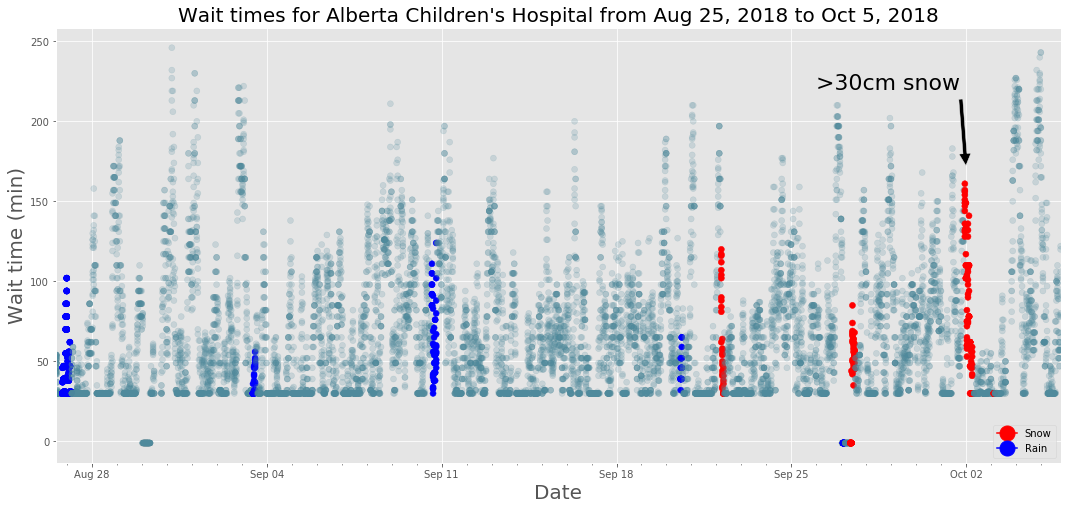

In [18]:
## Plotting entire time series with weather highlighted
from matplotlib.lines import Line2D


weatherDF = pd.read_csv("./MERGED_DATA.csv")
weatherDF = weatherDF[pd.notnull(weatherDF['sunset'])]

hospitalFrame = weatherDF[weatherDF.hospitalName == "Alberta Children's Hospital"].sort_values(by = 'date.x')
Dates = hospitalFrame['date.x'].map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
Times = hospitalFrame.waitTime
hospitalFrame['colors'] = hospitalFrame.description.map(lambda x: coloursDict[x])
Colors = hospitalFrame['colors']

fig, ax = plt.subplots()
ax.scatter(Dates.values, Times, color=Colors.values)

legend_elements = [Line2D([0], [0], marker='o', color='red',
                          label='Snow', markersize=15),
                   Line2D([0], [0], marker='o', color='blue', 
                          label='Rain', markersize=15)
                  ]
ax.legend(handles=legend_elements, loc='lower right')

plt.annotate(">30cm snow", 
    fontsize='22',
    xy=(datetime(2018, 10, 2), 170), 
    xytext=(datetime(2018, 9, 26), 220),
    arrowprops=dict(facecolor='black', shrink=0.05))

## format the ticks
days = mdates.DayLocator()
ax.xaxis.set_major_locator(days)

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.xaxis.set_minor_locator(mdates.DayLocator())

## Set the limits and labels
datemin = np.datetime64(Dates.values[0])
datemax = np.datetime64(Dates.values[-1])
ax.set_xlim(datemin - 10**7, datemax + 10**7)
fig.set_size_inches(18, 8)
plt.title("Wait times for Alberta Children's Hospital from Aug 25, 2018 to Oct 5, 2018", fontsize=20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Wait time (min)', fontsize=20)

### Comments

We can see that after a large snowfall occured, there was period of almost two full days where the wait time did not go over 60 minutes. The wait times during this period are noticably shorter than during the times just outside of that period.

## 8. Conclusion
<a id="conclusion"></a>

This investigation displayed some consistent time-dependent trends for the wait times in Alberta EDs. Across the province, the shortest times were found to be early in the morning, with the longer times later in the evening.

Through visual inspection of a time series it is difficult to notice a dependence of wait times on weather, but broadly speaking, worse weather leads to shorter wait times. An thorough statistical analysis is required to draw any conclusions about the effect of weather of ED wait times.

As more data is collected, wait times can be analysed at time scales of months instead of weeks. A wider range of weather can be captured to facilitate a more accurate investigation of its effects on wait times. As well, there are some questions can only be answered with data collected over the course of a full year:

- Are there some holidays, such as New Year's Eve, where wait times are very long?

- Are wait times on nights with full moons longer than average?

- Are wait times affected by whether or not public school is in session? Especially at the Children's Hospital?

Future data collection could also include hospitals from other provinces or even other countries - wherever data is continuously published online. For such a task consideration would must given to possibly different methods of calculating and reporting the expected wait time. A lesson learned is that it is a bit of a pain to download all of the data from AWS DynamoDB into a CSV format. Unfortunately, Dynamo doesn't come with an 'export to CSV' option, which would have saved a lot of time.

While the wait times published online are useful as a guide, they are only a proxy for the wait times actually experienced by visitors the ED. It is likely that AHS is collecting this data, as well as data about the number of visitors to EDs, the type of ailment for each visitor, and so on. A comparison of wait times published online and wait times actually experienced by patients would illuminate some important factors about how to appropriately estimate each patient's wait time. This information would help hospital administration with efficient resource planning, and also guide patients in the best way to make use of the ED. 